In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import utils

In [2]:
ROOT_PATH = Path('data/q1b')
OBJ_DATA_PATH = ROOT_PATH / 'ball'
GT_DATA_PATH = OBJ_DATA_PATH / 'gt.npz'
CORRESP_DATA_PATH = OBJ_DATA_PATH / 'corresp_noisy.npz'
INTRINSICS_PATH = OBJ_DATA_PATH / 'intrinsics.npz'
IMG1_PATH = OBJ_DATA_PATH / 'image1.jpg'
IMG2_PATH = OBJ_DATA_PATH / 'image2.jpg'

In [3]:
IMG1 = utils.load_image(IMG1_PATH)
IMG2 = utils.load_image(IMG2_PATH)

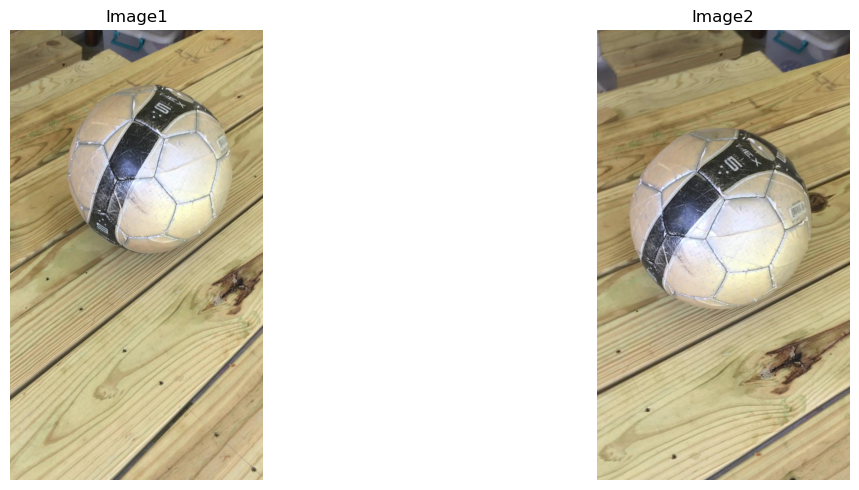

In [4]:
utils.show_images([IMG1, IMG2], ['Image1', 'Image2'])

In [5]:
K1 = np.load(INTRINSICS_PATH)['K1']
K2 = np.load(INTRINSICS_PATH)['K2']
print(f'K1: {K1.shape}\n{K1}')
print(f'K2: {K2.shape}\n{K2}')

K1: (3, 3)
[[1.96456304e+03 0.00000000e+00 5.31500000e+02]
 [0.00000000e+00 1.96456304e+03 9.44000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
K2: (3, 3)
[[1.96515338e+03 0.00000000e+00 5.31000000e+02]
 [0.00000000e+00 1.96515338e+03 9.44000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [6]:
pts1 = np.load(CORRESP_DATA_PATH)['pts1']
pts2 = np.load(CORRESP_DATA_PATH)['pts2']
print(f'pts1: {pts1.shape}\n{pts1}')
print(f'pts2: {pts2.shape}\n{pts2}')

pts1: (1613, 2)
[[   6.18689251 1225.15783691]
 [   7.16535234 1464.19848633]
 [   7.16535234 1464.19848633]
 ...
 [1054.82702637 1204.11047363]
 [1055.71508789  613.0489502 ]
 [1055.87768555 1870.97241211]]
pts2: (1613, 2)
[[ 632.08465576 1475.47607422]
 [1055.26257324  877.83544922]
 [1055.26257324  877.83544922]
 ...
 [ 886.15856934 1569.90515137]
 [1055.26257324  877.83544922]
 [ 385.57748413 1015.91625977]]


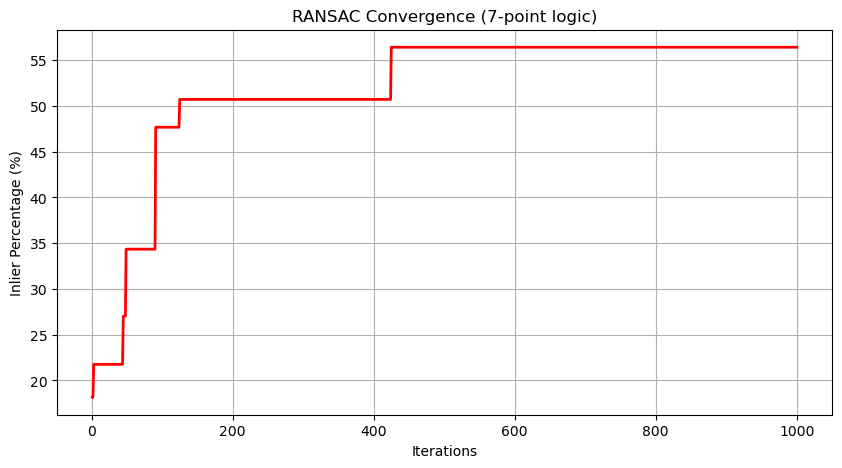

Fundamental Matrix F:
 [[ 2.48219810e-07 -2.12416118e-06 -9.62788309e-03]
 [ 2.70608689e-06 -8.50739888e-07 -1.74813113e-02]
 [ 1.27100329e-02  1.71954895e-02  1.00000000e+00]]
Kept 910 best points out of 1613


In [7]:
def sampson_distance(F, pts1, pts2):
    p1 = np.column_stack((pts1, np.ones(len(pts1))))
    p2 = np.column_stack((pts2, np.ones(len(pts2))))
    numerator = np.square(np.sum((p2 @ F) * p1, axis=1))
    Fp1 = p1 @ F.T
    FTp2 = p2 @ F
    denominator = Fp1[:, 0]**2 + Fp1[:, 1]**2 + FTp2[:, 0]**2 + FTp2[:, 1]**2
    return numerator / denominator

def estimate_model(p1, p2):
    return utils.compute_F_7points(p1, p2)
    
def run_ransac(pts1, pts2, iterations=1000, threshold=1.0):
    best_F = None
    best_inliers_count = 0
    best_inlier_mask = None
    inlier_history = [] 
    num_pts = len(pts1)

    for i in range(1, iterations + 1):
        indices = np.random.choice(num_pts, 7, replace=False)
        
        try:
            candidates = estimate_model(pts1[indices], pts2[indices])
            
            for F_cand in candidates:
                distances = sampson_distance(F_cand, pts1, pts2)
                mask = distances < threshold
                count = np.sum(mask)
                
                if count > best_inliers_count:
                    best_inliers_count = count
                    best_F = F_cand
                    best_inlier_mask = mask
        except:
            pass 
        
        inlier_history.append((best_inliers_count / num_pts) * 100)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, iterations + 1), inlier_history, color='red', linewidth=2)
    plt.title('RANSAC Convergence (7-point logic)')
    plt.xlabel('Iterations')
    plt.ylabel('Inlier Percentage (%)')
    plt.grid(True)
    plt.show()

    final_pts1 = pts1[best_inlier_mask]
    final_pts2 = pts2[best_inlier_mask]

    return best_F, final_pts1, final_pts2

best_F, final_pts1, final_pts2 = run_ransac(pts1, pts2, iterations=1000, threshold=1.0)

print("Fundamental Matrix F:\n", best_F)
print(f"Kept {len(final_pts1)} best points out of {len(pts1)}")

final_pts1 = final_pts1[:8, :]
final_pts2 = final_pts2[:8, :]

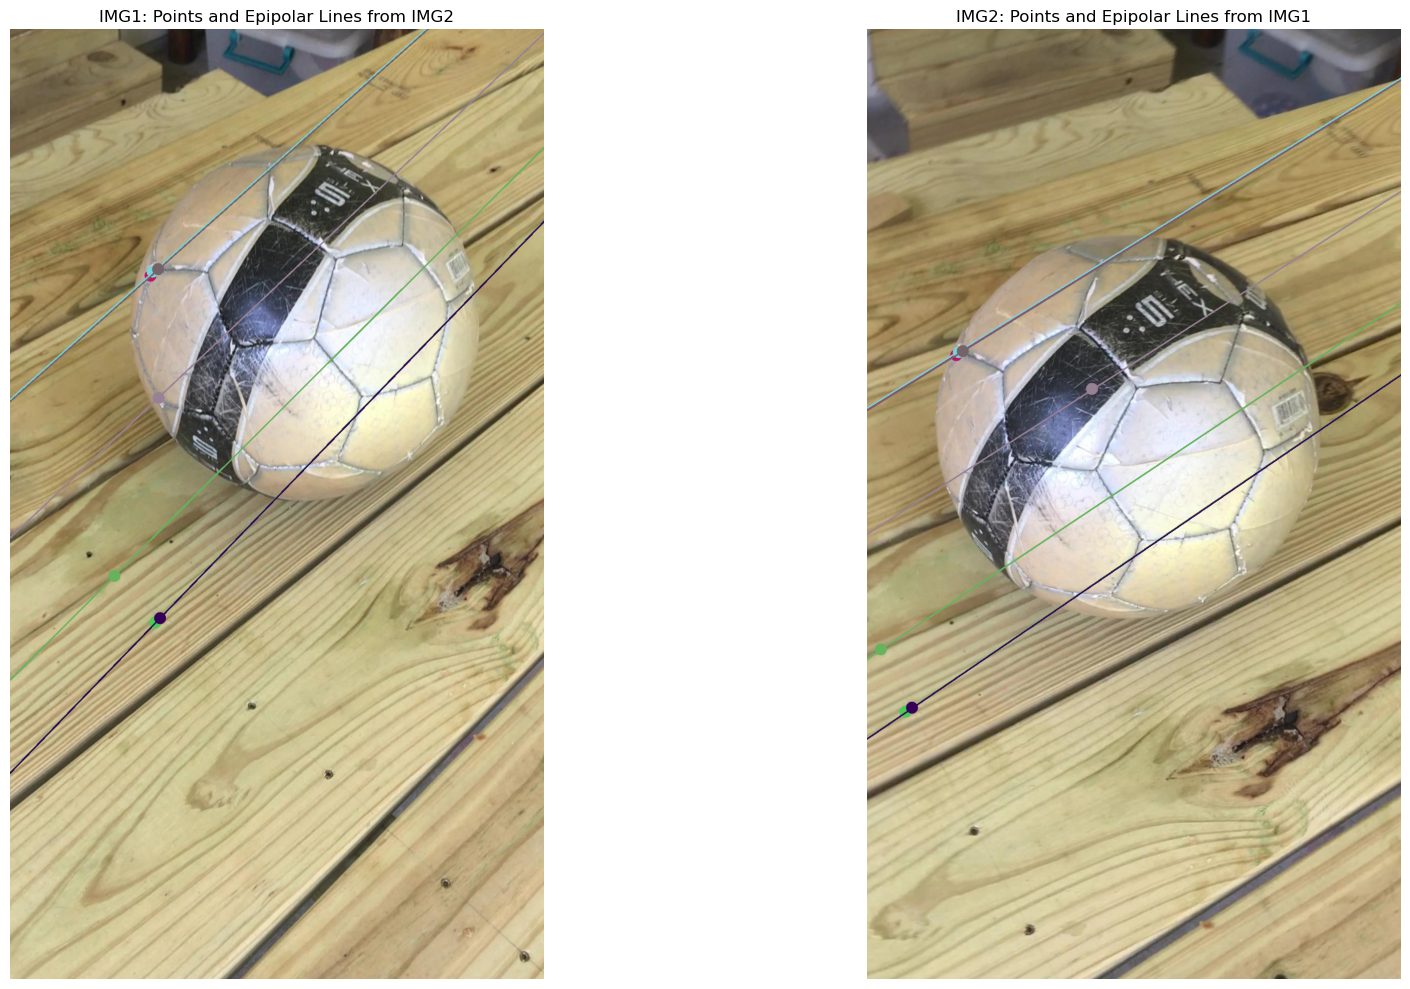

In [8]:
def draw_epipolar_viz(img1, img2, pts1, pts2, F):
    out1 = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2RGB)
    out2 = cv2.cvtColor(img2.copy(), cv2.COLOR_BGR2RGB)
    
    h, w = out1.shape[:2]
    
    pts1_h = np.column_stack((pts1, np.ones(len(pts1))))
    lines2 = (F @ pts1_h.T).T 
    
    pts2_h = np.column_stack((pts2, np.ones(len(pts2))))
    lines1 = (F.T @ pts2_h.T).T

    np.random.seed(42)
    colors = np.random.randint(0, 255, (len(pts1), 3)).tolist()

    for i in range(len(pts1)):
        color = colors[i]
        
        l1 = lines1[i]
        x0, y0 = 0, int(-l1[2] / l1[1])
        x1, y1 = w, int(-(l1[2] + l1[0] * w) / l1[1])
        cv2.line(out1, (x0, y0), (x1, y1), color, 2)
        cv2.circle(out1, tuple(pts1[i].astype(int)), 12, color, -1)
        
        l2 = lines2[i]
        x0, y0 = 0, int(-l2[2] / l2[1])
        x1, y1 = w, int(-(l2[2] + l2[0] * w) / l2[1])
        cv2.line(out2, (x0, y0), (x1, y1), color, 2)
        cv2.circle(out2, tuple(pts2[i].astype(int)), 12, color, -1)

    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(out1)
    plt.title("IMG1: Points and Epipolar Lines from IMG2")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(out2)
    plt.title("IMG2: Points and Epipolar Lines from IMG1")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

draw_epipolar_viz(IMG1, IMG2, final_pts1, final_pts2, best_F)

In [9]:
E_raw = K2.T @ best_F @ K1

U, S, Vt = np.linalg.svd(E_raw)

average_scale = (S[0] + S[1]) / 2.0

E = U @ np.diag([average_scale, average_scale, 0]) @ Vt

print("Essential Matrix E:\n", E)

Essential Matrix E:
 [[  1.20435113  -8.10395379 -22.95008987]
 [ 10.67761915  -3.30201331 -33.69927227]
 [ 29.78932756  29.44537125   1.72841163]]


In [10]:
p1_h = np.array([final_pts1[0,0], final_pts1[0,1], 1])
p2_h = np.array([final_pts2[0,0], final_pts2[0,1], 1])

p1_norm = np.linalg.inv(K1) @ p1_h
p2_norm = np.linalg.inv(K2) @ p2_h

error = p2_norm.T @ E @ p1_norm
print(f"Error for point 0: {error:.6f}")

Error for point 0: -0.208018
